# Экспериментальное исследование алгоритмов для регулярных запросов

## Постановка задачи
В данной работе исследуется задача достижимости в графе. 

Целью исследования являются ответы на следующие вопросы: 
- Какое представление разреженных матриц и векторов лучше подходит для каждой из решаемых задач?
- Начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные?

Для ответа на эти вопросы были поставлены следующие подзадачи:
- исследовать производительность `tensor_based_rpq` (задача решается для всех пар) на различных типах матриц
- исследовать производительность `ms_bfs_based_rpq` (задача решается для подмножества стартовых вершин) на различных типах матриц
- сравнить производительность `tensor_based_rpq` и `ms_bfs_based_rpq` на разных графах с различными регулярными запросами и размерами набора стартовых вершин

## Описание исследуемых решений,
Реализация алгоритмов `tensor based` и `ms bfs based` для решения поставленных задач представлена в `project.task3` и в `project.task4` соответственно. Тогда запросы будут выглядеть следующим образом:
1. Задача достижимости между всеми парами вершин:
    - `tensor_based_rpq(regex, graph, start_nodes = set(), final_nodes = set(), matrix_type)`
    - `ms_bfs_based_rpq(regex, graph, start_nodes = set(), final_nodes = set(), matrix_type)`
2. Достижимость для каждой вершины из заданного множества стартовых вершин:
    - `tensor_based_rpq(regex, graph, start_nodes, final_nodes = set(), matrix_type)`
    - `ms_bfs_based_rpq(regex, graph, start_nodes, final_nodes = set(), matrix_type)`

Где:
- `regex`— регулярные ограничения
- `graph`— граф, для которого решается задача достижимости
- `start_nodes`— множество стартовых вершин графа, если равно пустому множеству, то стартовыми вершинами будут все вершины графа
- `final_nodes`— конечные вершины графа, всегда выбираются все вершины по аналогии с `start_nodes`
- `matrix_type`— тип разреженных матриц и векторов, которые используются в алгоритме, в эксперименте будут использоваться [dok_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.dok_matrix.html#scipy.sparse.dok_matrix), [lil_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html#scipy.sparse.lil_matrix), [csc_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html#scipy.sparse.csc_matrix), [csr_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix)

## Описание набора данных для экспериментов

### Графы

В качестве тестовых были взяты графы из [набора](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/index.html):
- [skos](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/skos.html#skos) — 144 nodes, 252 edges;
- [wine](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/wine.html#pizza) — 733 nodes, 1839 edges;
- [funding](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/funding.html#funding) — 778 nodes, 1086 edges;

Такой выбор был сделан, чтобы протестировать графы, которые имеют различное количество рёбер и вершин, а также сравнить графы, с разным количеством рёбер, но с приблизительно одинаковым количеством вершин. 

В силу технических ограничений были выбраны графы относительно небольшого размера, способных поместиться в оперативную память, не прибегая к файлу подкачки, который заметно повлиял бы на скорость работы алгоритма. Также тестирование алгоритмов на данных графах происходит за приемлемое время, при достаточном количестве запусков алгоритмов, что обеспечивает точность эксперимента и нивелировании погрешности.

### Регулярные выражения

Использовались следующие регулярные выражения:

- `(l1 | l2)* l3`
- `(l3 | l4)+ l1*`
- `l1 l2 l3 (l4|l1)*`
- `(l1 | l2) (l3 | l4)`

## Описание эксперимента
### Оборудование

* **Процессор:** 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz   2.30 GHz
* **Кэш:** L1 - 640 Кб, L2 - 10 Мб, L3 - 24 Мб
* **Оперативная память:** 16,0 Гб
* **ОС:** Windows 11 23H2
* **Версия Python:** 3.12.5

### Подробности проведения замеров

Для ответа на каждый из поставленных вопросов было необходимо определить, какие параметры могли повлиять на результат исследования. Были проведены тесты со всеми комбинациями следующих параметров: граф, запросы, матрицы, алгоритмы и стартовые вершины. Все результаты были записаны в таблицу, которую можно проанализировать для ответа на каждый отдельный вопрос. Каждый замер одной комбинации параметров проводился 20 раз и выводилось его среднее значение со стандартным отклонением.

## Эксперимент
### Импорт библиотек и подготовка тестовых параметров

**Этап 1**. Для начала импортируем все необходимые библиотеки и тестируемые функции

In [20]:
from project.task1 import get_info_from_graph_name, get_graph_by_name
from project.task3 import tensor_based_rpq
from project.task4 import ms_bfs_based_rpq
from itertools import product
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd
import numpy as np
import scipy.sparse as sp
import cfpq_data
import time

**Этап 2.** Внесем в отдельные структуры данных все наборы тестируемых параметров. Такой подход поможет очень просто вложенными циклами перебрать всевозможные комбинации, занести их в таблицу и проанализировать время, фиксируя интересующие параметры

In [21]:
def generate_requests_for_graph(name: str):
    num_of_the_most_common_labels = 4
    labels = get_info_from_graph_name(name)[2][:num_of_the_most_common_labels]
    return (
        f"({labels[0]} | {labels[1]})* {labels[2]}",
        f"({labels[2]} | {labels[3]})+ {labels[0]}*",
        f"{labels[0]} {labels[1]} {labels[2]} ({labels[3]}|{labels[0]})*",
        f"({labels[0]} | {labels[1]}) ({labels[2]} | {labels[3]})",
    )

In [22]:
def generate_start_nodes(graph, num: int):
    seed = 0x3AEBCA
    return cfpq_data.generate_multiple_source(graph, num, seed=seed)

In [23]:
def generate_start_sets(graphs):
    start_set_percents = [0.05, 0.2, 0.4, 0.7]
    sets = {
        graph_name: {
            int(i * 100): generate_start_nodes(
                graphs[graph_name], round(graphs[graph_name].number_of_nodes() * i)
            )
            for i in start_set_percents
        }
        for graph_name in graphs.keys()
    }
    for i in graphs.keys():
        sets[i][100] = set()
    return sets

In [24]:
graph_names = ["skos", "wine", "funding"]
algorithms = {"Tensor": tensor_based_rpq, "MS BFS": ms_bfs_based_rpq}


matrices_types = {
    matrix_name: matrix
    for matrix_name, matrix in zip(
        ["CSR", "CSC", "Lil", "Dok"],
        [sp.csr_matrix, sp.csc_matrix, sp.lil_matrix, sp.dok_matrix],
    )
}


test_graphs = {
    graph_name: graph
    for graph_name, graph in zip(
        graph_names, [get_graph_by_name(name) for name in graph_names]
    )
}

graph_regex = (
    "(l1 | l2)* l3",
    "(l3 | l4)+ l1*",
    "l1 l2 l3 (l4|l1)*",
    "(l1 | l2) (l3 | l4)",
)

graph_requests = {
    graph_name: generate_requests_for_graph(graph_name) for graph_name in graph_names
}

start_sets = generate_start_sets(test_graphs)

[2024-10-14 21:54:11]>INFO>Found graph with name='skos'
[2024-10-14 21:54:12]>INFO>Load archive graph_archive=WindowsPath('D:/projects/formal-lang-course/.venv/Lib/site-packages/cfpq_data/data/graphs/skos.tar.gz')
[2024-10-14 21:54:12]>INFO>Unzip graph name='skos' to file graph=WindowsPath('D:/projects/formal-lang-course/.venv/Lib/site-packages/cfpq_data/data/graphs/skos/skos.csv')
[2024-10-14 21:54:12]>INFO>Remove archive graph_archive=WindowsPath('D:/projects/formal-lang-course/.venv/Lib/site-packages/cfpq_data/data/graphs/skos.tar.gz')
[2024-10-14 21:54:12]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x000002D34B2AD9D0> from path=WindowsPath('D:/projects/formal-lang-course/.venv/Lib/site-packages/cfpq_data/data/graphs/skos/skos.csv')
[2024-10-14 21:54:12]>INFO>Found graph with name='wine'
[2024-10-14 21:54:12]>INFO>Load archive graph_archive=WindowsPath('D:/projects/formal-lang-course/.venv/Lib/site-packages/cfpq_data/data/graphs/wine.tar.gz')
[2024-10-14 2

**Этап 3**. Подготовим структуру данных `measures`, которая впоследствии станет базой для таблицы результатов и установим количество замеров. Также стоит отметить, что помимо выбранных параметров в таблице располагается среднее время, нормальное отклонение и интервал доверия.



In [25]:
num_of_tests = 30
measures = {
    "Graph": [],
    "Matrix type": [],
    "Algorithm": [],
    "Regex": [],
    "Start set, %": [],
    "Mean Time, s": [],
    "Std Dev, s": [],
    "Confidence interval, s": [],
}

### Тестирование

**Этап 1**. Подготовим функцию обертку `measure_time` над тестируемой функцией, которая будет замерять ее время выполнения, а также функцию обертку `measure_series`, которая будет замерять серию результатов и вносить массив

In [26]:
def measure_time(func, regex, graph, start_nodes, matrix_type):
    start_time = time.perf_counter()
    func(regex, graph, start_nodes, set(), matrix_type)
    end_time = time.perf_counter()
    delta = end_time - start_time
    return delta


def measure_series(func, graph, regex, start_nodes, num_tests, matrix_type):
    return [
        measure_time(func, regex, graph, start_nodes, matrix_type)
        for _ in range(num_tests)
    ]

**Этап 2**. Подготовим функцию тестирования. Как было сказано ранее функция эксперимента будет состоять из множества вложенных циклов. Таким нехитрым образом вносим результаты замеров в таблицу

In [27]:
def performance_test():
    for graph in test_graphs.keys():
        for matrix_type in matrices_types.keys():
            for algorithm in algorithms.keys():
                for request, regex in zip(graph_requests[graph], graph_regex):
                    for percent in start_sets[graph].keys():
                        row_time = measure_series(
                            algorithms[algorithm],
                            test_graphs[graph],
                            request,
                            start_sets[graph][percent],
                            num_of_tests,
                            matrices_types[matrix_type],
                        )

                        mean_time = np.mean(row_time)
                        std_dev = round(np.std(row_time, ddof=1), 6)
                        ci95 = st.t.ppf(0.975, df=len(row_time) - 1) * st.sem(row_time)
                        confidence_interval = tuple(
                            round(num, 6)
                            for num in (mean_time - ci95, mean_time + ci95)
                        )

                        measures["Graph"].append(graph)
                        measures["Matrix type"].append(matrix_type)
                        measures["Algorithm"].append(algorithm)
                        measures["Regex"].append(regex)
                        measures["Start set, %"].append(percent)
                        measures["Mean Time, s"].append(mean_time)
                        measures["Std Dev, s"].append(std_dev)
                        measures["Confidence interval, s"].append(confidence_interval)

**Этап 3**. Запустим функцию тестирования и выведем полученные результаты

In [28]:
performance_test()

D:\projects\formal-lang-course\.venv\Lib\site-packages\scipy\sparse\_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
D:\projects\formal-lang-course\.venv\Lib\site-packages\scipy\sparse\_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


In [29]:
result = pd.DataFrame.from_dict(measures)
result

,Graph,Matrix type,Algorithm,Regex,"Start set, %","Mean Time, s","Std Dev, s","Confidence interval, s"
0,skos,CSR,Tensor,(l1 | l2)* l3,5,0.049360,0.014546,"(0.043929, 0.054792)"
1,skos,CSR,Tensor,(l1 | l2)* l3,20,0.034172,0.000950,"(0.033817, 0.034527)"
2,skos,CSR,Tensor,(l1 | l2)* l3,40,0.036088,0.010538,"(0.032153, 0.040023)"
3,skos,CSR,Tensor,(l1 | l2)* l3,70,0.033709,0.000904,"(0.033371, 0.034046)"
4,skos,CSR,Tensor,(l1 | l2)* l3,100,0.035970,0.012664,"(0.031241, 0.040699)"
...,...,...,...,...,...,...,...,...
475,funding,Dok,MS BFS,(l1 | l2) (l3 | l4),5,0.046052,0.018996,"(0.038959, 0.053145)"
476,funding,Dok,MS BFS,(l1 | l2) (l3 | l4),20,0.074438,0.017369,"(0.067952, 0.080924)"
477,funding,Dok,MS BFS,(l1 | l2) (l3 | l4),40,0.117954,0.018930,"(0.110885, 0.125022)"
478,funding,Dok,MS BFS,(l1 | l2) (l3 | l4),70,0.167420,0.019832,"(0.160014, 0.174825)"


## Результаты и анализ

Напишем функцию построения графиков для наглядного представления результатов

In [67]:
def create_bar(
    name,
    percents=(5, 20, 40, 70, 100),
    algos=algorithms.keys(),
    matrices=matrices_types.keys(),
):
    for percent, algo in product(percents, algos):
        index = np.arange(4)
        bw = 0.2
        plt.title(
            f"Graph {name} with {percent}% of start nodes and {algo} algorithm",
            fontsize=15,
        )
        plt.xticks(index + 1.5 * bw, graph_regex)
        percent_result = result[
            (result["Start set, %"] == percent)
            & (result["Algorithm"] == algo)
            & (result["Graph"] == name)
        ]
        colors = ["b", "r", "g", "m"]
        for i, matrix in enumerate(matrices):
            matrix_result = percent_result[
                (percent_result["Matrix type"] == matrix)
                & (percent_result["Algorithm"] == algo)
            ]
            plt.bar(
                index + i * bw,
                matrix_result["Mean Time, s"].values,
                bw,
                color=colors[i],
                yerr=matrix_result["Std Dev, s"].values,
                error_kw={"ecolor": "0.1", "capsize": 6},
                label=matrix,
            )
        plt.legend(loc=2)
        plt.show()

Давайте теперь рассмотрим таблицу поподробнее

### Влияние матриц

На примере графа `skos` рассмотрим влияние матриц на работу алгоритма

Сравнивать будем в пределах одного алгоритма, не сравнивая их друг с другом, потому что на это влияет множество стартовых вершин, что будет рассмотрено далее

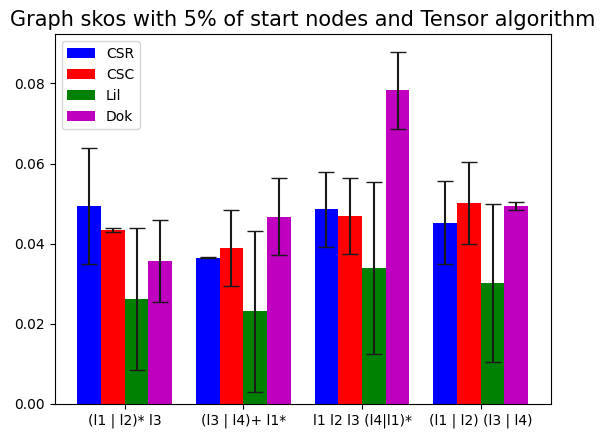

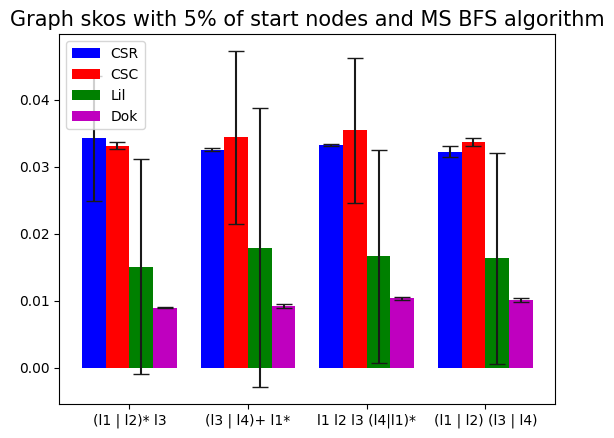

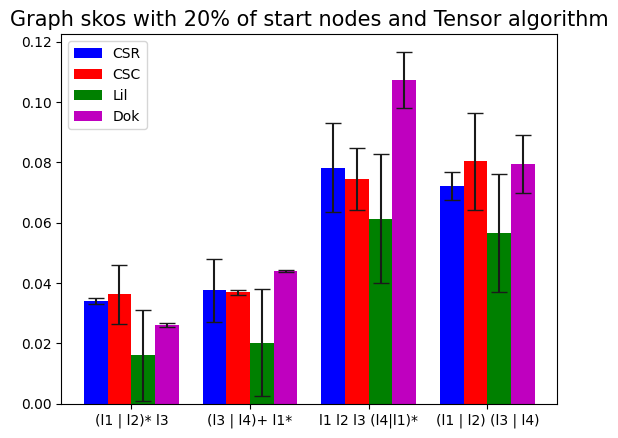

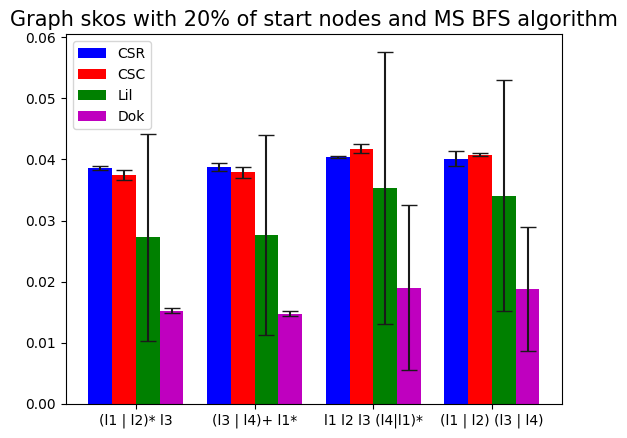

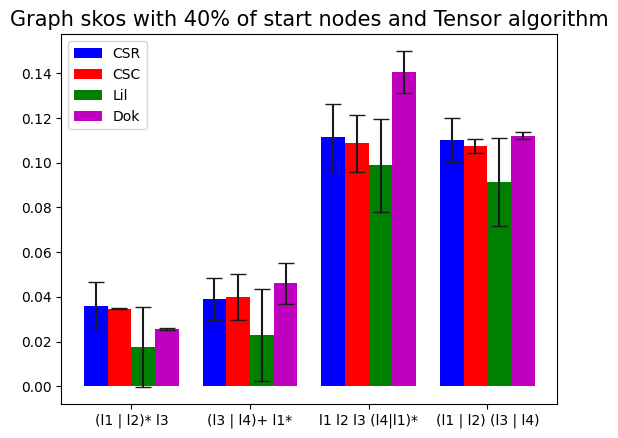

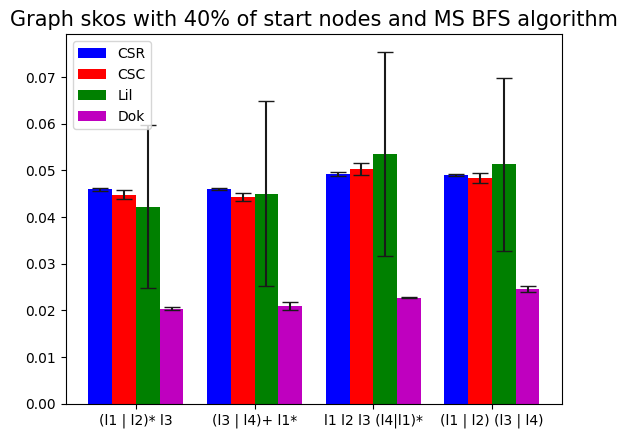

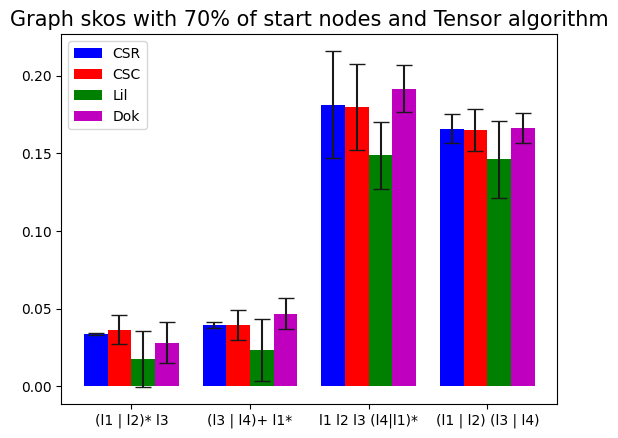

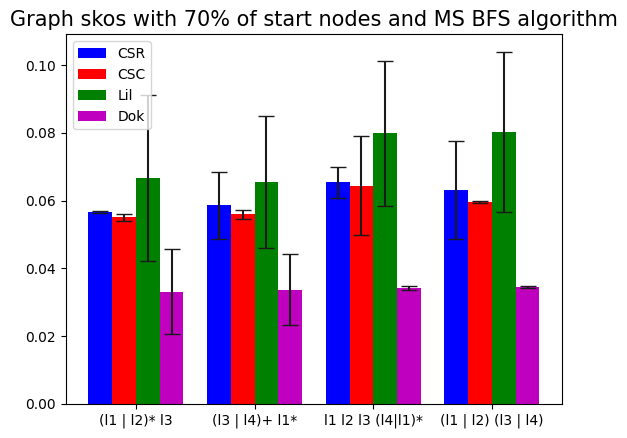

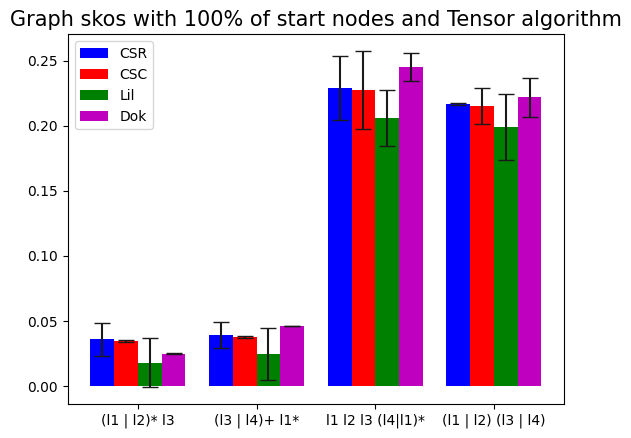

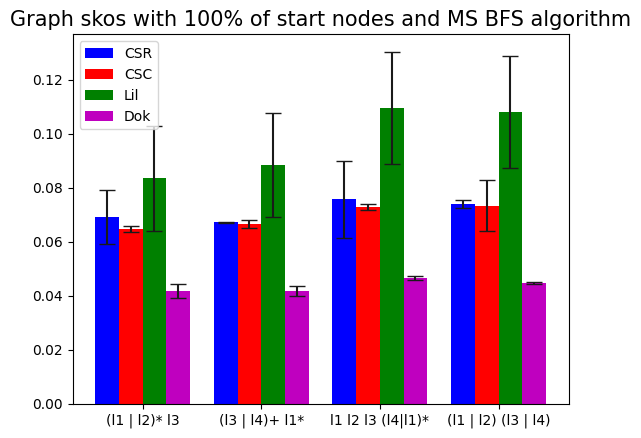

In [68]:
create_bar("skos")

Как можно заметить `ms_bfs` работает существенно быстрее на `dok` матрицах, в то время как `tensor` отрабатывает немного быстрее на `lil` матрице. Наибольшую стабильность оба алгоритма показали на csc и csr матрицах.

#### Влияние стартовых вершин
На примере графа `wine` рассмотрим влияние количества стартовых вершин на скорость алгоритмов.

Для большей честности исключим матрицу `lil` для `ms_bfs` алгоритма и `dok` матрицу для `tensor based`

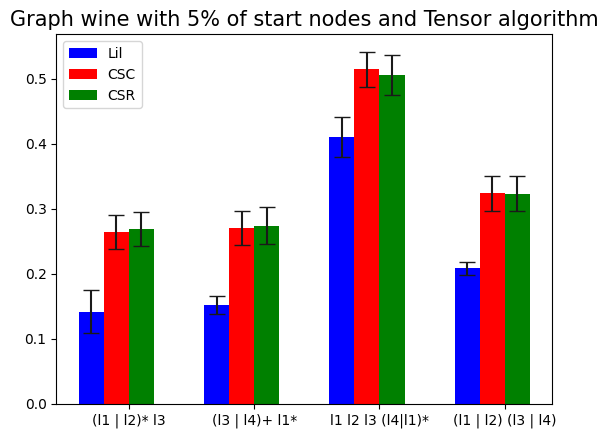

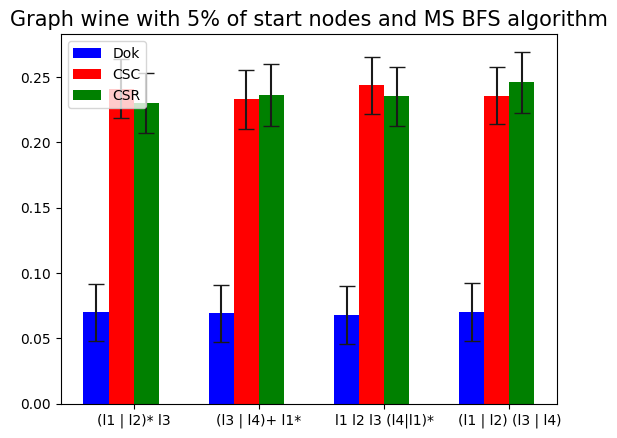

In [69]:
create_bar(
    "wine",
    percents=[5],
    algos=["Tensor"],
    matrices=["Lil", "CSC", "CSR"],
)
create_bar("wine", percents=[5], algos=["MS BFS"], matrices=["Dok", "CSC", "CSR"])

Как можно заметить на 5% стартовых вершин алгоритм `ms bfs` показывает себя почти в два раза лучше, чем `tensor` для каждой из матриц и запроса. Оставим матрицы `dok` и `lil` для `ms bfs` и `tensor` соответственно, как самые быстрые

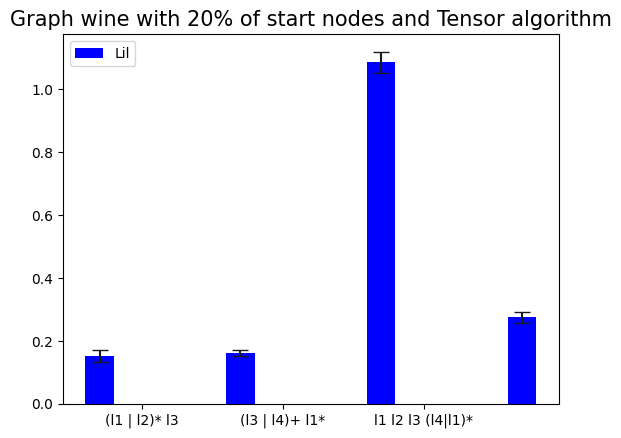

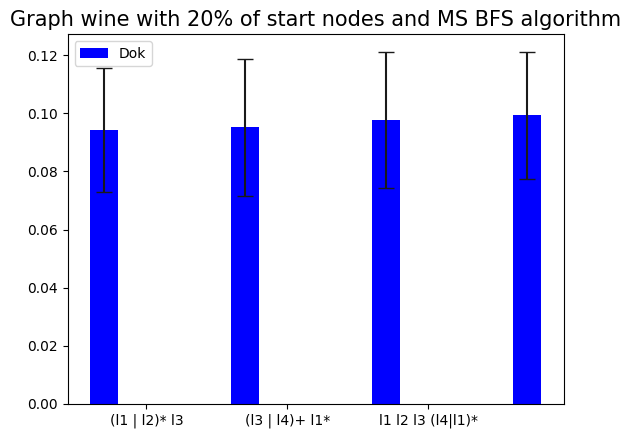

In [70]:
create_bar("wine", percents=[20], algos=["Tensor"], matrices=["Lil"])
create_bar("wine", percents=[20], algos=["MS BFS"], matrices=["Dok"])

Можно увидеть, что `ms bfs` все еще показывает результаты получше, но уже с небольшим отрывом примерно в 1.5 раза, за исключением неудобного для `tensor` запроса `l1 l2 l3 (l4|l1)*`, на котором он проигрывает более, чем в 10 раз. Сложно сказать причину такого огромного разрыва, это можно списать на несовершенство алгоритма в конкретном случае. Далее сценарий с этим запросом будет повторяться, и так как это описано здесь, писать далеепро данный феномен не буду

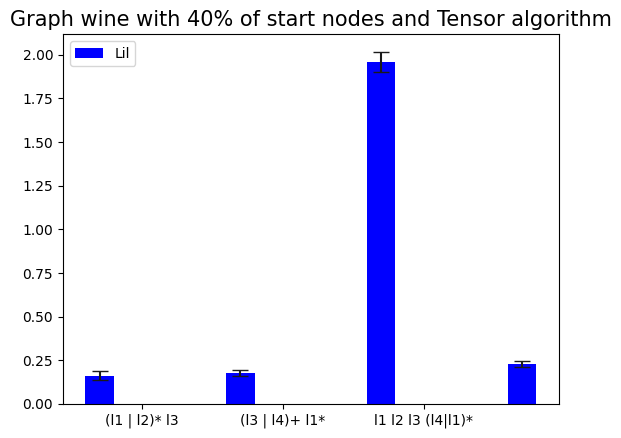

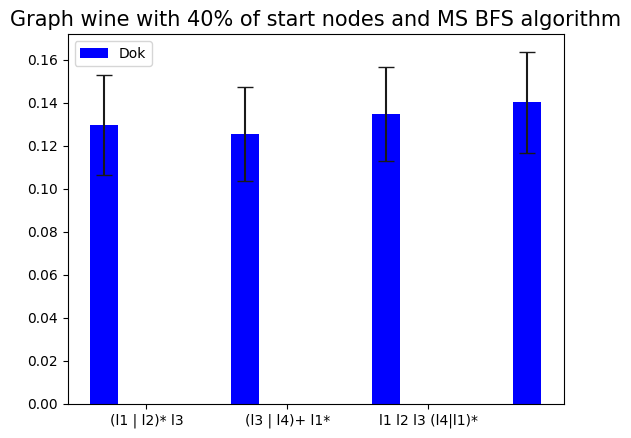

In [71]:
create_bar(
    "wine",
    percents=[40],
    algos=["Tensor"],
    matrices=["Lil"],
)
create_bar("wine", percents=[40], algos=["MS BFS"], matrices=["Dok"])

Можно увидеть, что `ms bfs` показывает схожие результаты, но все еще немного лучше. Посмотрим для 70 и 100 процентов одновременно

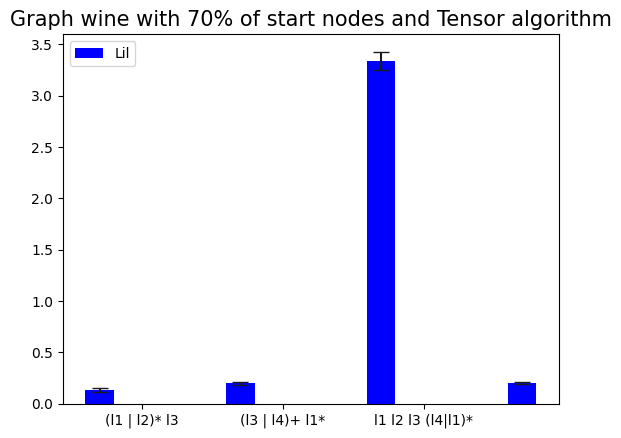

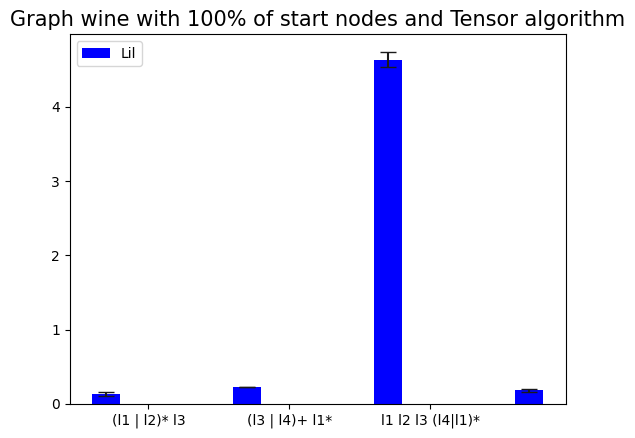

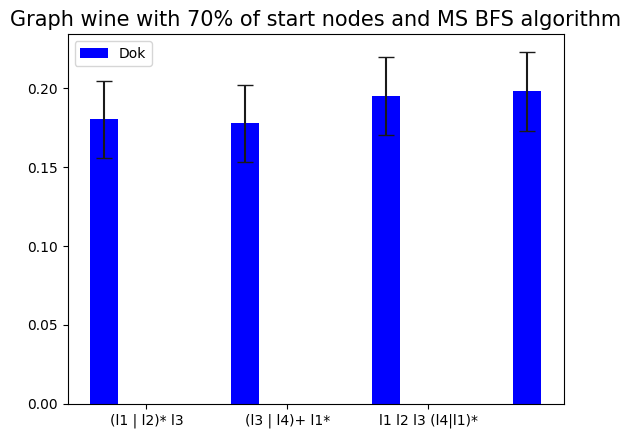

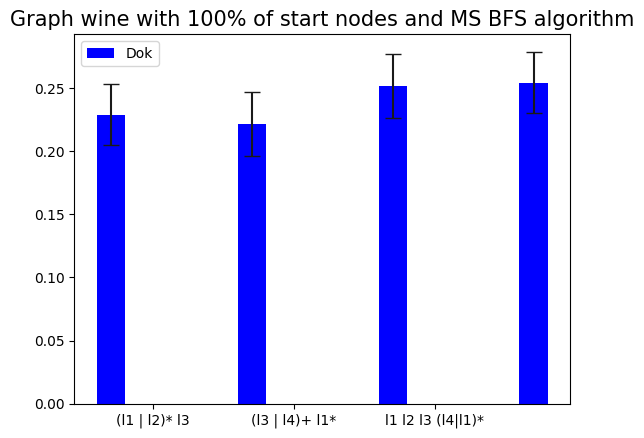

In [72]:
create_bar(
    "wine",
    percents=[70, 100],
    algos=["Tensor"],
    matrices=["Lil"],
)
create_bar("wine", percents=[70, 100], algos=["MS BFS"], matrices=["Dok"])

Можно увидеть, что `ms bfs` уже значительно отстает от `tensor` на больших процентах и всем множестве вершин.

### Рассмотрим результаты для funding и сравним с wine

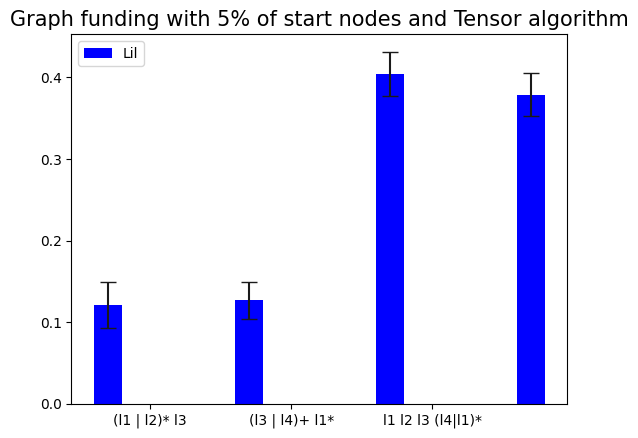

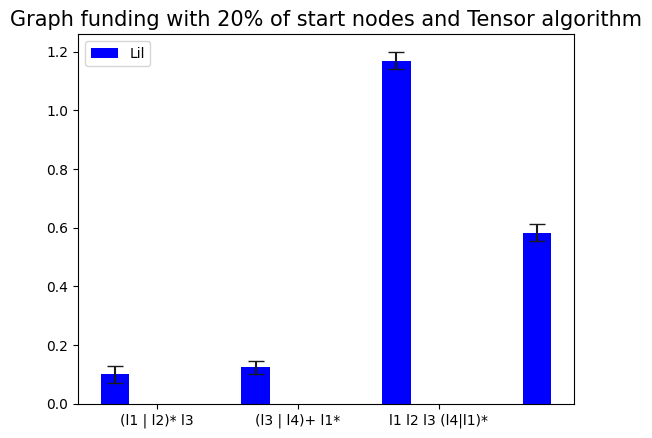

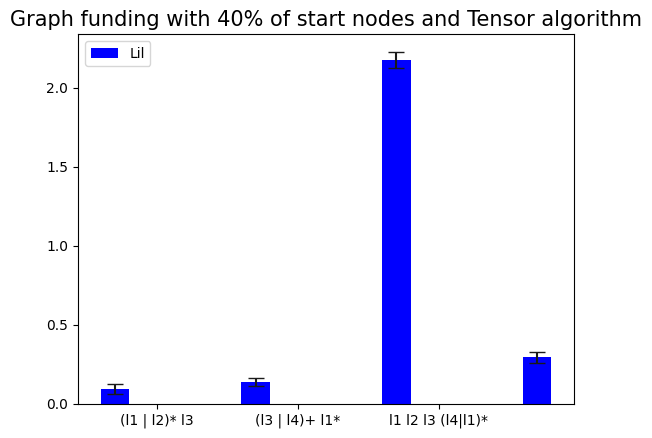

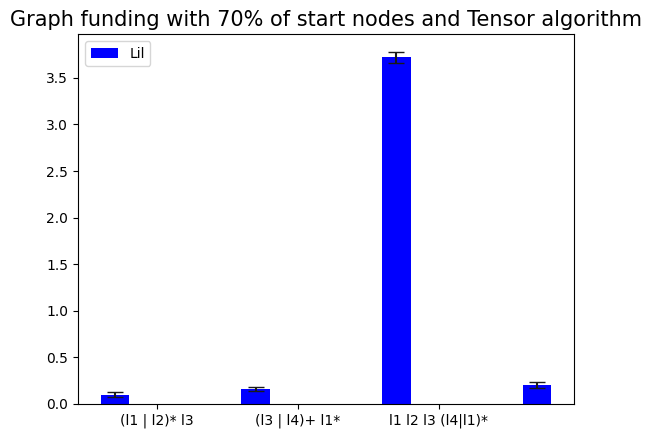

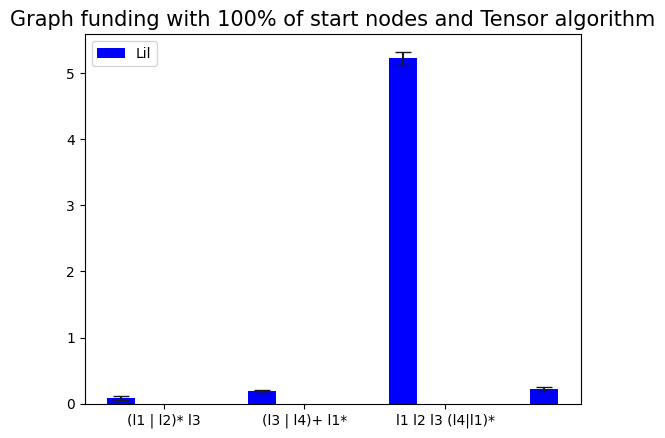

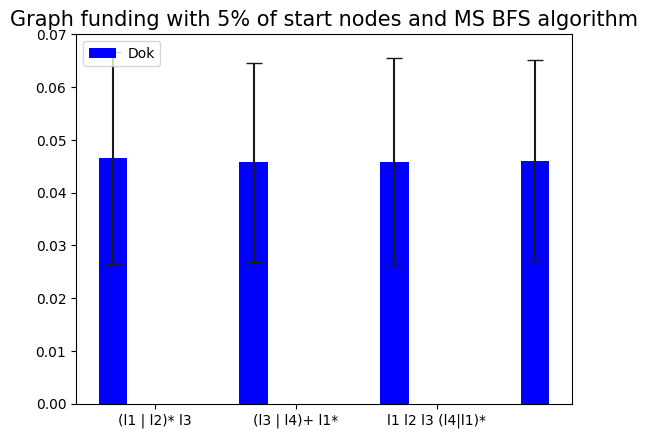

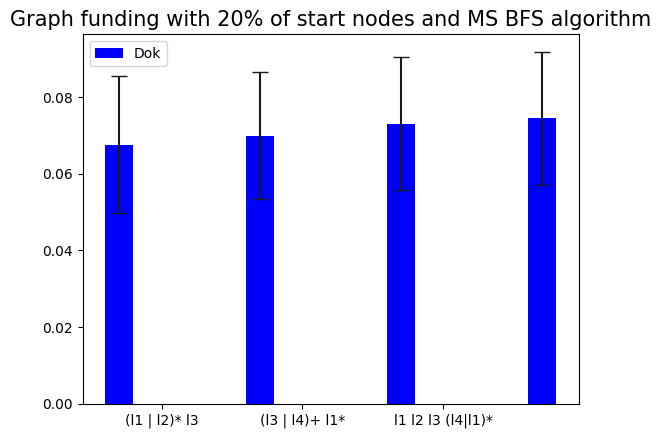

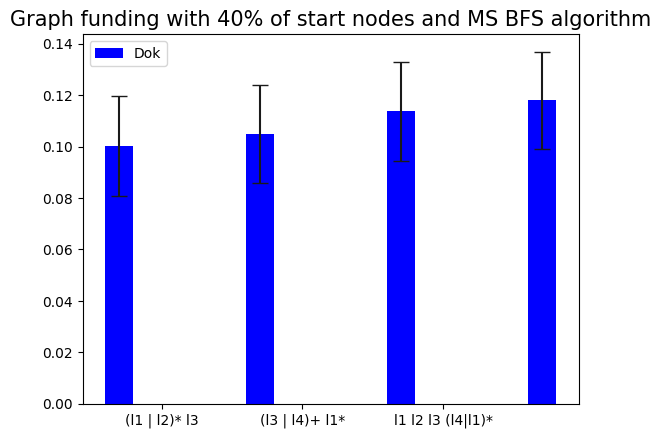

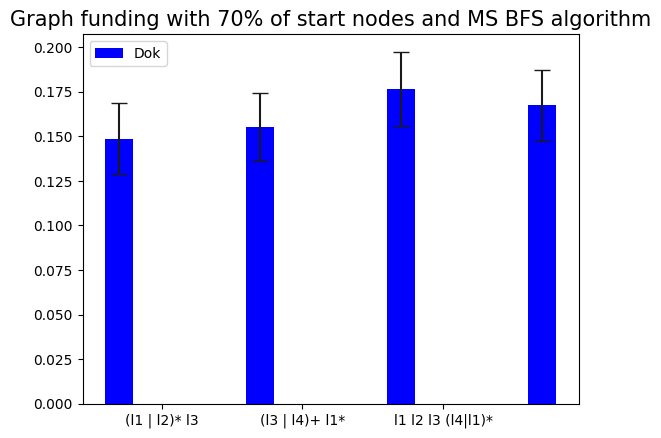

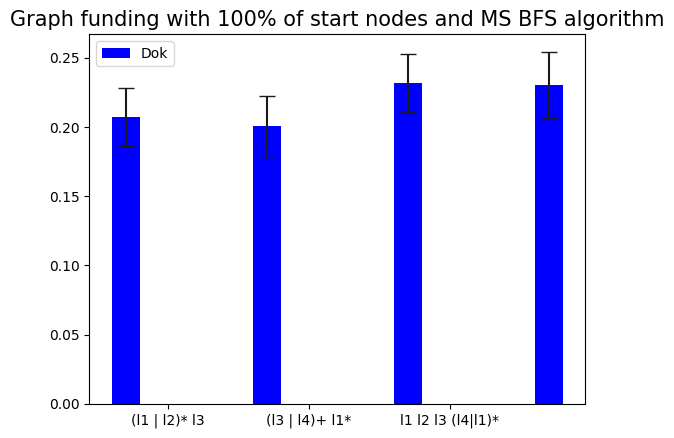

In [77]:
create_bar(
    "funding",
    algos=["Tensor"],
    matrices=["Lil"],
)
create_bar("funding", algos=["MS BFS"], matrices=["Dok"])

Получаем аналогичные для `wine` результаты - при количестве стартовых вершин больше 40% выгоднее решать задачу для всех стартовых вершин с помощью `tensor`. И такие затруднения `tensor` на запросе `l1 l2 l3 (l4|l1)*`

## Выводы

1. Для `tensor` алгоритма наиболее предпочтительным вариантом будет `lil` матрица, хуже всего `dok`. `csr` и `csc` показывают себя стабильно средне
2. Для `ms bfs` алгоритма лучше всего подходит `dok` матрица, `lil` матрица тоже неплохо себя показывает, но с ростом количества стартовых вершин разрыв между ней и `dok` будет все более существенной. `csr` и `csc` также показывают себя стабильно средне
3. При размере стартового множества вершин больше 40% выгоднее решать задачу с помощью `tensor` алгоритма. Для множества меньше 20% выгоднее оказывается `ms bfs`.
4. `tensor` алгоритм крайне странно себя ведет на конкретных запросах, что можно списать на несовершенство кода и требует отдельного анализа. Остальные случаи являются достаточно репрезентативными